# eReefs dataset cross section

## Load the required Python libraries

First of all, load the necessary libraries.

In [1]:
import os
import numpy as np

import datetime as dt

import netCDF4
from netCDF4 import Dataset, num2date

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

## Connect to the OpeNDAP endpoint for a specified month. 

We query the server based on the OPeNDAP URL for a specific file "EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-YYYY-MM.nc". 


- **gbr4**: we use the Hydrodynamic 4km model and daily data for the month specified

In [4]:
month = 4
year = 2019

netCDF_datestr = str(year)+'-'+format(month, '02')
print('File chosen time interval:',netCDF_datestr)

# GBR4 HYDRO
#inputFile = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"+netCDF_datestr+".nc"

# GBR4 BIO
inputFile = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"+netCDF_datestr+".nc"

File chosen time interval: 2019-04


We now load the dataset within the Jupyter environment...

In [5]:
nc_data = Dataset(inputFile, 'r')

print('Get the list of variable in the file:')
print(list(nc_data.variables.keys()))

ncdata = nc_data.variables

Get the list of variable in the file:
['alk', 'BOD', 'Chl_a_sum', 'CO32', 'DIC', 'DIN', 'DIP', 'DOR_C', 'DOR_N', 'DOR_P', 'Dust', 'EFI', 'FineSed', 'Fluorescence', 'HCO3', 'Kd_490', 'MPB_Chl', 'MPB_N', 'Mud-carbonate', 'Mud-mineral', 'Nfix', 'NH4', 'NO3', 'omega_ar', 'Oxy_sat', 'Oxygen', 'P_Prod', 'PAR', 'PAR_z', 'pco2surf', 'PH', 'PhyL_Chl', 'PhyL_N', 'PhyS_Chl', 'PhyS_N', 'PhyS_NR', 'PIP', 'salt', 'TC', 'temp', 'TN', 'TP', 'Tricho_Chl', 'Tricho_N', 'Z_grazing', 'ZooL_N', 'ZooS_N', 'zc', 'time', 'latitude', 'longitude', 'CH_N', 'CS_bleach', 'CS_Chl', 'CS_N', 'EpiPAR_sg', 'eta', 'MA_N', 'MA_N_pr', 'month_EpiPAR_sg', 'R_400', 'R_410', 'R_412', 'R_443', 'R_470', 'R_486', 'R_488', 'R_490', 'R_510', 'R_531', 'R_547', 'R_551', 'R_555', 'R_560', 'R_590', 'R_620', 'R_640', 'R_645', 'R_665', 'R_667', 'R_671', 'R_673', 'R_678', 'R_681', 'R_709', 'R_745', 'R_748', 'R_754', 'R_761', 'R_764', 'R_767', 'R_778', 'Secchi', 'SG_N', 'SG_N_pr', 'SG_shear_mort', 'SGD_N', 'SGD_N_pr', 'SGD_shear_mort', 'SG

To get information for a specific variables, we can use the following:

In [6]:
ncdata['alk']

<class 'netCDF4._netCDF4.Variable'>
float32 alk(time, k, latitude, longitude)
    coordinates: time zc latitude longitude
    short_name: alk
    units: mmol m-3
    long_name: Total alkalinity
    _ChunkSizes: [  1   1 133 491]
unlimited dimensions: time
current shape = (30, 17, 723, 491)
filling off

In [7]:
ncdata['alk'].long_name

'Total alkalinity'

In [8]:
ncdata['alk'].units

'mmol m-3'

## Load variables

We then load the file dataset in Jupyter

In [9]:
# Starting with the spatial domain
lat = ncdata['latitude'][:]
lon = ncdata['longitude'][:]

print('eReefs model spatial extent:\n')
print(' - Longitudinal extent:',lon.min(),lon.max())
print(' - Latitudinal extent:',lat.min(),lat.max())

eReefs model spatial extent:

 - Longitudinal extent: 142.168788 156.868788
 - Latitudinal extent: -28.696022 -7.036022


In [28]:
# Get time span of the dataset
time_var = ncdata['time']

# Starting time
dtime = netCDF4.num2date(time_var[0],time_var.units)
daystr = dtime.strftime('%Y-%b-%d %H:%M')
print(' - start time: ',daystr,'\n')

# Ending time
dtime = netCDF4.num2date(time_var[-1],time_var.units)
daystr = dtime.strftime('%Y-%b-%d %H:%M')
print(' - end time: ',daystr,'\n')

ntime = len(time_var)
print(' - Number of time steps',ntime,'\n')

zc = ncdata['zc'][:]
nlay = len(zc)

print('Number of vertical layers',nlay)

 - start time:  2019-Apr-01 02:00 

 - end time:  2019-Apr-30 02:00 

 - Number of time steps 30 

Number of vertical layers 17


## Cross section

Let's make a cross section along the latitude 11 S. 

The AIMS dataset has been resample on a regular grid, so first we find the closest point to the desired latitude. 

In [12]:
def find_nearest(array, value):
    '''
    Find index of nearest value in a numpy array
    '''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return idx

We will then extract all the point along this latitude:

In [17]:
def eReefs_cross_data(dataname, latID=None, lonID=None):
    
    '''
    This function extracts specified dataset along a latitude or longitude.
    
    args:
    - dataname: specified variable name 
    - latID: latitudinal index
    - lonID: longitudinal index
    '''
    
    # Get data
    if latID is not None:
        data = ncdata[dataname][:, :, latID, :]
    elif lonID is not None:
        data = ncdata[dataname][:, :, :, lonID]
    
    return data

Now let's start run this function...

In [27]:
selectedLatIndex = find_nearest(lat,-11.)
selectedLonIndex = find_nearest(lon,148)

selectedVariable = 'alk' 
alkLat = eReefs_cross_data(selectedVariable, selectedLatIndex, None)
alkLon = eReefs_cross_data(selectedVariable, None, selectedLonIndex)

In [19]:
print(' ')
print('Data range: ')
print(np.nanmin(alkLat),np.nanmax(alkLat))

 
Data range: 
2161.4448 2272.7104


We then define the plotting function:

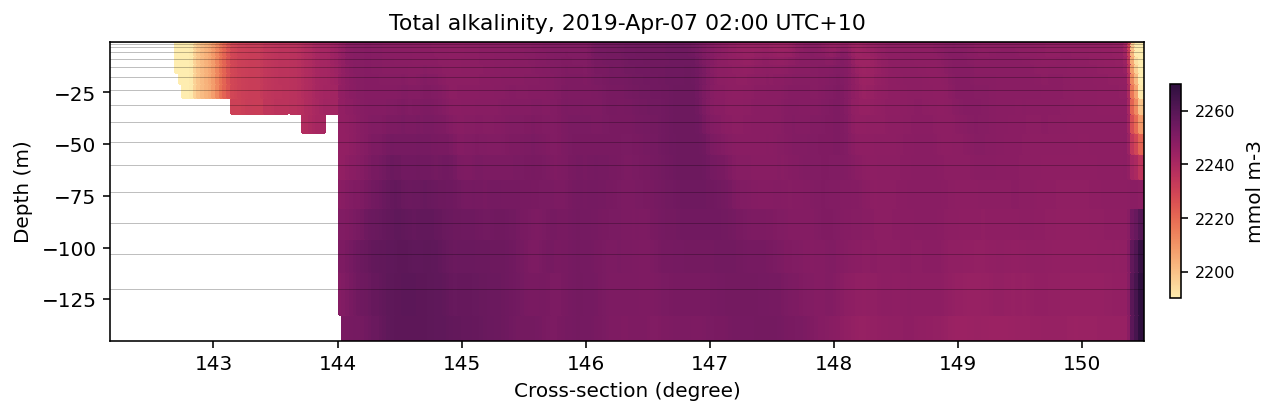

<Figure size 432x288 with 0 Axes>

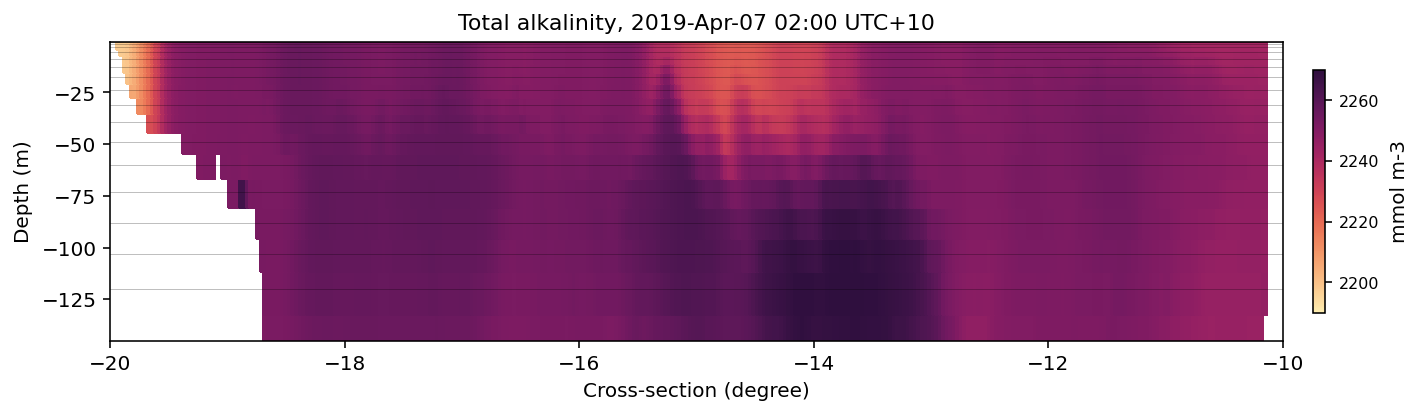

<Figure size 432x288 with 0 Axes>

In [26]:
def plot_cross_section(tstep, xdata, ydata, xmin, xmax, dmin, dmax, color, 
                       size, fname, show=True, save=False):

    fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

    ax = plt.axes()
    plt.xlabel('Cross-section (degree)')
    plt.ylabel('Depth (m)')

    plt.xlim(xmin, xmax)
    plt.ylim(zc.min(), zc.max())

    cm = plt.pcolormesh(xdata, zc, ydata[tstep,:,:],  
                   cmap = color,  
                   vmin = dmin,  
                   vmax = dmax, 
                   edgecolors = 'face', 
                   shading ='auto') 

    dtime = netCDF4.num2date(time_var[tstep],time_var.units)
    daystr = dtime.strftime('%Y-%b-%d %H:%M')
    plt.title(ncdata[selectedVariable].long_name+', %s UTC+10' % (daystr), fontsize=11);

    # Color bar
    cbar = fig.colorbar(cm, ax=ax, fraction=0.01, pad=0.025)
    cbar.set_label(ncdata[selectedVariable].units, rotation=90, labelpad=5, fontsize=10)
    cbar.ax.tick_params(labelsize=8)
    
    # Get z-coordinate lines
    for k in range(len(zc)):
        plt.plot([xmin, xmax],[zc[k],zc[k]],lw=0.5,c='k',alpha=0.25)
        
    
    if show:
        if save:
            plt.savefig(f"{fname}_cross_time{tstep:04}.png",dpi=300, 
                    bbox_inches='tight')
        plt.tight_layout()
        plt.show()
    else:
        plt.savefig(f"{fname}_cross_time{tstep:04}.png",dpi=300, 
                bbox_inches='tight')

    fig.clear()
    plt.close(fig)
    plt.clf()

    return

color = cmocean.cm.matter
fname = 'lat11'
xmin = lon.min() 
xmax = 150.5
size = (9,3)

dmin = 2190.
dmax = 2270.
plot_cross_section(6, lon, alkLat, xmin, xmax, dmin, dmax, color, 
                   size, fname, show=True, save=False)

fname = 'lon148'
xmin = -20
xmax = -10
size = (10,3)
plot_cross_section(6, lat, alkLon, xmin, xmax, dmin, dmax, color, 
                   size, fname, show=True, save=False)